In [1]:
#%% Add to path
import sys
%cd ..

with open('python_paths.txt', 'r') as f:
    paths = f.read().splitlines()
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

        
print(sys.path)
print(sys.executable)


/media/theodore/HDD1/These/projets/semisup
['/media/theodore/HDD1/These/projets/semisup/Notebooks', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages/SimpleITK-1.2.0rc2.dev1162+g2a79d-py3.7-linux-x86_64.egg', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages/IPython/extensions', '/home/theodore/.ipython', '/media/theodore/HDD1/These/projets/semisup', './']
/media/theodore/HDD1/Spondi/SpondiDetect/venv/bin/python3


In [2]:
#%% Reload modules
from importlib import reload
import random

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import src.models.mlp as mlp

def reload_modules():
    for mudl in [mlp]:
        reload(mudl)
        
reload_modules()

# 2d

In [3]:
n = 1000
yoff = 2.5
omga = 5

def f1(xs, yoff=yoff, omga=omga):
    return np.cos(omga*xs) - yoff / 2 + np.random.rand(len(xs))

def f2(xs, yoff=yoff, omga=omga):
    return np.cos(omga*xs) + yoff / 2 + np.random.rand(len(xs))

def fopt(xs, omga=omga):
    return np.cos(omga*xs) + .5

xs1 = np.linspace(0, 1, n) + np.random.rand(n)
xs2 = np.linspace(0, 1, n) + np.random.rand(n)

xs = np.concatenate([xs1, xs2])  # First coordinate
ys = np.concatenate([f1(xs1), f2(xs2)])  # Second coordinate
cs = np.concatenate([np.zeros(n), np.ones(n)])  # Class

Xs = np.c_[xs, ys]

In [4]:
nlabels = 50
lab = random.sample(range(len(xs)), nlabels)
unlab = list(set(np.arange(len(xs))).difference(lab))

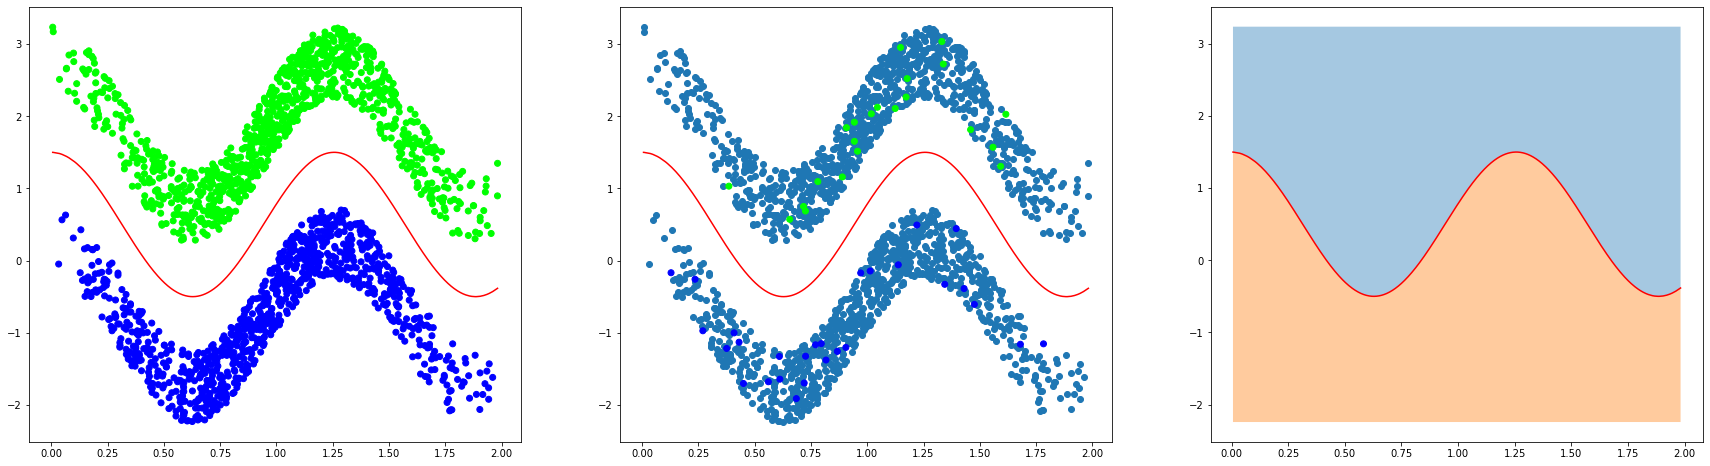

In [5]:
nax = 3

fig, axs = plt.subplots(1, nax, figsize=(10*nax, 8))

axs[0].scatter(xs, ys, c=cs, cmap='brg')
axs[0].plot(sorted(xs), fopt(np.array(sorted(xs))), c='r')

axs[1].scatter(xs[unlab], ys[unlab])
axs[1].scatter(xs[lab], ys[lab], c=cs[lab], cmap='brg')
axs[1].plot(sorted(xs), fopt(np.array(sorted(xs))), c='r')

axs[2].plot(sorted(xs), fopt(np.array(sorted(xs))), c='r')
axs[2].fill_between(sorted(xs), fopt(np.array(sorted(xs))), max(max(f2(xs)), max(f1(xs))), alpha=.4)
axs[2].fill_between(sorted(xs), min(min(f2(xs)), min(f1(xs))), fopt(np.array(sorted(xs))), alpha=.4)

## SVM

In [3]:
def plot_decision_svm(ax, model, xs, ys, alpha=.8, h=.02):
    x_min, x_max = xs.min() - .2, xs.max() + .2
    y_min, y_max = ys.min() - .2, ys.max() + .2

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=alpha)
    
    return ax

In [212]:
model = svm.SVC(kernel='linear', degree=1, verbose=True, tol=1e-10, C=2, shrinking=False)
# model = svm.LinearSVC(verbose=True, max_iter=100000, tol=1e-10, C=2)
X = np.c_[xs[lab], ys[lab]]
model.fit(X, cs[lab])

[LibSVM]

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=False,
    tol=1e-10, verbose=True)

Errors: 0


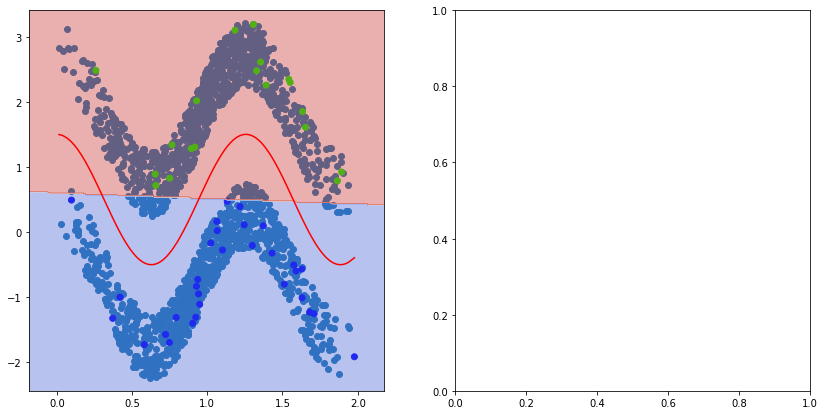

In [213]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].scatter(xs[unlab], ys[unlab])
axs[0].scatter(xs[lab], ys[lab], c=cs[lab], cmap='brg')
axs[0].plot(sorted(xs), fopt(np.array(sorted(xs))), c='r')
plot_decision_svm(axs[0], model, xs, ys, alpha=.4)

print("Errors:", (model.predict(np.c_[xs[lab], ys[lab]]) != cs[lab]).sum())

## MLP

In [48]:
def train_mlp(model, X, y, loss_fn, optimizer, batch_size=10, epochs=5,):
    
    n_samples = len(X)
    n_batches = n_samples // batch_size + 1
    
    loss_values = []
    accs = []
    contours = []
    
    for epoch_idx in range(1, epochs+1):
        for batch_idx in range(n_batches):
            inputs = X[batch_idx * batch_size:(batch_idx+1) * batch_size]
            labels = y[batch_idx * batch_size:(batch_idx+1) * batch_size]
            if len(inputs) == 0:
                continue
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            loss_values.append(loss.item())
            accs.append((outputs.argmax(1) == labels).float().mean().item())

            contours.append(compute_contours_nn(model, xs, ys))
            
    
    return loss_values, accs, contours
            
def plot_decision_nn(ax, model, xs, ys, alpha=.8, h=.02):
    compute_contours_nn(model, xs, ys, h)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=alpha)
    return ax

def compute_contours_nn(model, xs, ys, h=.02):
    x_min, x_max = xs.min() - .2, xs.max() + .2
    y_min, y_max = ys.min() - .2, ys.max() + .2

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32)).argmax(1)
    Z = Z.reshape(xx.shape)
    
    return xx, yy, Z

In [49]:
neurons = [Xs.shape[1], 2]
model = mlp.MLP(neurons, F.relu)
# model = nn.Linear(*neurons)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

trainset = torch.tensor(Xs[lab]).type(torch.float32)
labels = torch.tensor(cs[lab]).to(int)

loss_values, accs, contours = train_mlp(
    model, trainset, labels, loss_fn, optimizer, batch_size=10, epochs=20)


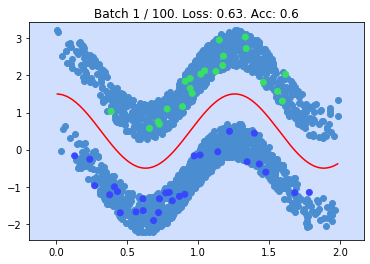

In [50]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
plt.scatter(xs[unlab], ys[unlab])
plt.scatter(xs[lab], ys[lab], c=cs[lab], cmap='brg')
plt.plot(sorted(xs), fopt(np.array(sorted(xs))), c='r')
cont = plt.contourf(*contours[0], cmap=plt.cm.coolwarm, alpha=.4)

def animate(i):
    global cont
    x, y, z = contours[i]
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(x, y, z, cmap=plt.cm.coolwarm, alpha=.4)
    plt.title(f"Batch {i+1} / {len(contours)}."
              f" Loss: {round(loss_values[i], 2)}."
              f" Acc: {round(accs[i], 2)}")
    return cont

anim = animation.FuncAnimation(
    fig, animate, frames=len(contours), interval=200, repeat=False)
HTML(anim.to_html5_video())

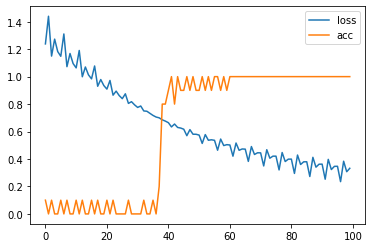

In [34]:
plt.plot(loss_values, label='loss')
plt.plot(accs, label='acc')
plt.legend()

In [473]:
len(contours)

20

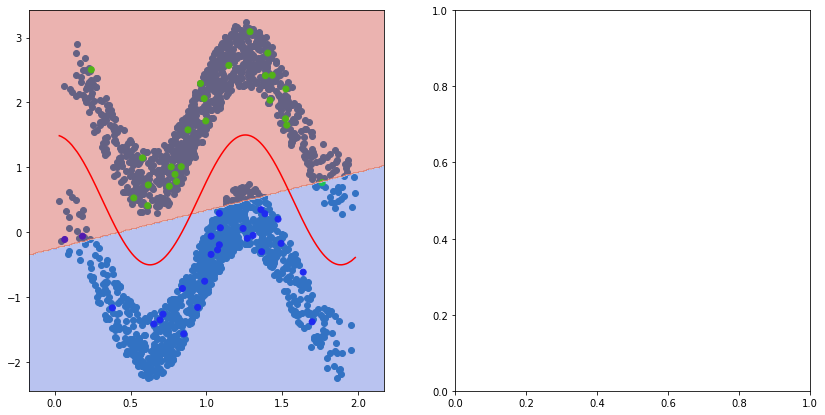

In [441]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].scatter(xs[unlab], ys[unlab])
axs[0].scatter(xs[lab], ys[lab], c=cs[lab], cmap='brg')
axs[0].plot(sorted(xs), fopt(np.array(sorted(xs))), c='r')
plot_decision_nn(axs[0], model, xs, ys, alpha=.4)

# print("Errors:", (model(np.c_[xs[lab], ys[lab]]) != cs[lab]).sum())

In [294]:
h = 0.4

x_min, x_max = xs.min() - .2, xs.max() + .2
y_min, y_max = ys.min() - .2, ys.max() + .2

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32))
Z = Z.reshape(xx.shape)

RuntimeError: shape '[15, 6]' is invalid for input of size 180

In [296]:
Z.shape

torch.Size([90, 2])

In [297]:
xx.shape

(15, 6)